In [1]:
!nvidia-smi

Sat Oct 12 16:27:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                    0 |
| N/A   46C    P0   148W / 400W |  63078MiB / 81251MiB |     99%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel, GPT2Tokenizer
from sklearn.decomposition import PCA
from torch import nn
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
import matplotlib.pyplot as plt
import time
import pandas as pd

In [3]:
# knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_simple.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,visi filkom,menjadi fakultas yang berdaya saing internasio...
1,misi filkom,menyelenggarakan pendidikan di bidang teknolog...
2,apa tujuan filkom?,"menghasilkan lulusan yang kompeten , profesion..."
3,sasaran pendidikan filkom,meningkatkan kompetensi dan kualifikasi pendid...
4,email fitra a. bachtiar,fitra.bachtiar[at]ub.ac.id
5,bidang penelitian fitra a. bachtiar,"affective computing, affective engineering, in..."
6,tanggal dibentuk ptiik,27 oktober 2011
7,sasaran pengabdian filkom,1. meningkatkan kualitas dan kuantitas pengabd...
8,sasaran kerjasama filkom,"1. mengadakan kerjasama pendidikan, penlitian ..."
9,dekan fakultas ilmu komputer filkom,"prof. ir. wayan firdaus mahmudy, s.si., mt., p..."


In [4]:
knowledgebase_eval_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_eval.xlsx'
knowledgebase_eval = pd.read_excel(knowledgebase_eval_url)

qa_paired_eval = knowledgebase_eval.drop(columns=knowledgebase_eval.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired_eval.dropna(inplace=True)
qa_paired_eval

,Pertanyaan,Jawaban
0,apa visi fakultas,menjadi fakultas yang berdaya saing internasio...
1,visi dari filkokm,menjadi fakultas yang berdaya saing internasio...
2,apa saja visi filkom,menjadi fakultas yang berdaya saing internasio...
3,apa misi fakultas,menyelenggarakan pendidikan di bidang teknolog...
4,apa saja misi flkom,menyelenggarakan pendidikan di bidang teknolog...
...,...,...
69,apa manfaat konseling filkom,1. masalah ditangani oleh ahli yang kompeten d...
70,berikan informasi mengenai layanan konseling,informasi mengenai layanan konseling dapat dia...
71,siapa konselor bimbingan dan konseling di filkom,ada 2 konselor bimbingan dan konseling di filk...
72,siapa koordinator konselor sebaya,koordinator konselor sebaya adalah muhammad da...


In [5]:
enc_tokenizer = AutoTokenizer.from_pretrained('firqaaa/indo-sentence-bert-base')
enc_model = AutoModel.from_pretrained('firqaaa/indo-sentence-bert-base')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# model_name_dec = 'flax-community/gpt2-medium-indonesian'
model_name_dec = 'indonesian-nlp/gpt2-medium-indonesian'

dec_model = GPT2LMHeadModel.from_pretrained(model_name_dec)
dec_tokenizer = GPT2Tokenizer.from_pretrained(model_name_dec)

dec_tokenizer.add_tokens(['[PRE1]'])
dec_tokenizer.add_tokens(['[PRE2]'])
dec_tokenizer.add_tokens(['[PRE3]'])
dec_tokenizer.add_tokens(['[PRE4]'])
dec_tokenizer.add_tokens(['[PRE5]'])
dec_tokenizer.add_tokens(['[PRE6]'])
dec_tokenizer.add_tokens(['[PRE7]'])

dec_tokenizer.add_special_tokens({'pad_token': '[PAD]',
                                    'bos_token': '[BOS]',
                                    'eos_token': '[EOS]',
                                    'sep_token': '[SEP]',})

# Add a new token to the tokenizer
dec_model.config.pad_token_id = dec_tokenizer.pad_token_id
dec_model.config.bos_token_id = dec_tokenizer.bos_token_id
dec_model.config.eos_token_id = dec_tokenizer.eos_token_id
dec_model.config.sep_token_id = dec_tokenizer.sep_token_id

dec_model.resize_token_embeddings(len(dec_tokenizer))

Embedding(50268, 1024)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc_model = enc_model.to(device)
dec_model = dec_model.to(device)

In [8]:
qa_paired_test = qa_paired
qa_paired_test = qa_paired_test.applymap(lambda x: x.lower() if isinstance(x, str) else x)
qa_paired_test['Jawaban'] = qa_paired_test['Jawaban'].apply(lambda x: '[BOS]' + x + '[EOS]')
qa_paired_test = qa_paired_test.reset_index(drop=True)
qa_paired_test

,Pertanyaan,Jawaban
0,visi filkom,[BOS]menjadi fakultas yang berdaya saing inter...
1,misi filkom,[BOS]menyelenggarakan pendidikan di bidang tek...
2,apa tujuan filkom?,"[BOS]menghasilkan lulusan yang kompeten , prof..."
3,sasaran pendidikan filkom,[BOS]meningkatkan kompetensi dan kualifikasi p...
4,email fitra a. bachtiar,[BOS] fitra.bachtiar[at]ub.ac.id[EOS]
5,bidang penelitian fitra a. bachtiar,"[BOS]affective computing, affective engineerin..."
6,tanggal dibentuk ptiik,[BOS]27 oktober 2011[EOS]
7,sasaran pengabdian filkom,[BOS]1. meningkatkan kualitas dan kuantitas pe...
8,sasaran kerjasama filkom,"[BOS]1. mengadakan kerjasama pendidikan, penli..."
9,dekan fakultas ilmu komputer filkom,"[BOS]prof. ir. wayan firdaus mahmudy, s.si., m..."


In [9]:
class FLUENTSOTA(nn.Module):
    def __init__(self, enc_model, dec_model, enc_tokenizer, dec_tokenizer, max_length=200):
        super(FLUENTSOTA, self).__init__()
        self.enc_model = enc_model
        self.dec_model = dec_model
        self.enc_tokenizer = enc_tokenizer
        self.dec_tokenizer = dec_tokenizer
        self.enc_mapper = nn.Linear(768, 1024)
        self.enc_mapper2 = nn.Linear(1024, 1024)
        self.prefix_nn = nn.Linear(1024, 1024)
        self.prefix_nn2 = nn.Linear(1024, 1024)
        self.prefix_nn3 = nn.Linear(1024, 1024)
        self.prefix_nn4 = nn.Linear(1024, 1024)
        self.prefix_nn5 = nn.Linear(1024, 1024)
        self.prefix_nn6 = nn.Linear(1024, 1024)
        self.prefix_nn7 = nn.Linear(1024, 1024)
        self.max_length = max_length
    
    def encoding(self, sentence):
        tokens = self.enc_tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        tokens = tokens.to(device)
        with torch.no_grad():
            output = self.enc_model(**tokens)
        enc_logits = output.last_hidden_state.mean(dim=1)
        enc_logits = self.enc_mapper(enc_logits).to(device)
        enc_logits = self.enc_mapper2(enc_logits).to(device)
        return enc_logits

    def get_embedding(self, sentence):
        tokens = self.dec_tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        tokens = tokens.to(device)
        wte = self.dec_model.get_input_embeddings()
        return wte(tokens['input_ids'])

    def dec_tokenizer(self, sentence):
        tokens = self.dec_tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        return tokens

    def add_prefix(self, enc_logits):
        prefix_1 = self.prefix_nn(enc_logits)
        prefix_2 = self.prefix_nn2(enc_logits)
        prefix_3 = self.prefix_nn3(enc_logits)
        prefix_4 = self.prefix_nn4(enc_logits)
        prefix_5 = self.prefix_nn5(enc_logits)
        prefix_6 = self.prefix_nn6(enc_logits)
        prefix_7 = self.prefix_nn7(enc_logits)

        prefixs = torch.stack((prefix_1, prefix_2, prefix_3, prefix_4, prefix_5, prefix_6, prefix_7), dim=1)
        return prefixs

    def decoding(self, enc_logits, target):
        prefixs = self.add_prefix(enc_logits)
        embed = self.get_embedding(target)
        pref_with_embed = torch.cat((prefixs, embed), dim=1)
        output = self.dec_model(inputs_embeds=pref_with_embed)
        return output

    def decoding_train(self, enc_logits, target, target_with_pre):
        prefixs = self.add_prefix(enc_logits)
        embed = self.get_embedding(target)
        pref_with_embed = torch.cat((prefixs, embed), dim=1)
        output = self.dec_model(inputs_embeds=pref_with_embed, labels=target_with_pre)
        return output

    def generate(self, quest):
        enc_logits = self.encoding(quest)
        prefix_se = '[BOS]'
        prefix_dec_embed = self.get_embedding(prefix_se)
        prefixs = self.add_prefix(enc_logits)
        
        pref_with_embed = torch.cat((prefixs, prefix_dec_embed), dim=1)

        output = self.dec_model.generate(   inputs_embeds=pref_with_embed, 
                                            max_length=self.max_length, 
                                            pad_token_id=self.dec_model.config.eos_token_id)
        returned_output = []
        for i in range(len(output[0])):
            if output[0][i] != self.dec_model.config.eos_token_id:
                returned_output.append(output[0][i])
            else:
                break
        return torch.tensor(returned_output).unsqueeze(0)

In [10]:
for param in enc_model.parameters():
    param.requires_grad = False

for param in dec_model.parameters():
    param.requires_grad = False

for param in dec_model.transformer.h[:-15].parameters():
    param.requires_grad = True

for param in enc_model.encoder.layer[:-15].parameters():
    param.requires_grad = True


In [11]:
model = FLUENTSOTA(enc_model, dec_model, enc_tokenizer, dec_tokenizer)
model.to(device)

FLUENTSOTA(
  (enc_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [12]:
all_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
untrainable_params = all_params - trainable_params

print(f'All parameters: {all_params:,}')
print(f'Trainable parameters: {trainable_params:,} ({trainable_params/all_params*100:.2f}%)')
print(f'Untrainable parameters: {untrainable_params:,} ({untrainable_params/all_params*100:.2f}%)')

All parameters: 488,460,032
Trainable parameters: 122,550,272 (25.09%)
Untrainable parameters: 365,909,760 (74.91%)


In [13]:
def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    cum_bleu_score_1 = 0
    cum_bleu_score_2 = 0
    cum_bleu_score_3 = 0
    cum_bleu_score_4 = 0

    num_of_rows_calculated = 0
    smoothing_function = SmoothingFunction().method1

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        # print(f"Question: {question}")
        # print(f"Real Answer: {real_answer}")
        # print(f"Predicted Answer: {preds[i]}")
        refs = [real_answer.split(' ')]
        hyp = preds[i].split(' ')

        bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoothing_function)
        bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0), smoothing_function=smoothing_function)
        bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0), smoothing_function=smoothing_function)
        bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1), smoothing_function=smoothing_function)
        cum_bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smoothing_function)
        cum_bleu_score_2 += sentence_bleu(refs, hyp, weights=(0.5,0.5,0,0), smoothing_function=smoothing_function)
        cum_bleu_score_3 += sentence_bleu(refs, hyp, weights=(0.33,0.33,0.33,0), smoothing_function=smoothing_function)
        cum_bleu_score_4 += sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothing_function)

        num_of_rows_calculated+=1

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_4/num_of_rows_calculated),
                "cumulative-1-gram": (cum_bleu_score_1/num_of_rows_calculated),
                "cumulative-2-gram": (cum_bleu_score_2/num_of_rows_calculated),
                "cumulative-3-gram": (cum_bleu_score_3/num_of_rows_calculated),
                "cumulative-4-gram": (cum_bleu_score_4/num_of_rows_calculated)}

    return results

def count_bleu_score(model_count, real_answers, questions):
    preds = []
    for question in questions:
        outputs = model_count.generate(question)
        decoded_output = model_count.dec_tokenizer.decode(outputs[0])
        preds.append(decoded_output)
    return calculate_bleu(preds, questions, real_answers)

In [14]:
bleu_score_eval = pd.DataFrame(columns=['Epoch', '1-gram', '2-gram', '3-gram', '4-gram', 'cumulative-1-gram', 'cumulative-2-gram', 'cumulative-3-gram', 'cumulative-4-gram'])
bleu_score_train = pd.DataFrame(columns=['Epoch', '1-gram', '2-gram', '3-gram', '4-gram', 'cumulative-1-gram', 'cumulative-2-gram', 'cumulative-3-gram', 'cumulative-4-gram'])

questions = qa_paired_test['Pertanyaan'].apply(lambda x: x.lower().replace('[BOS]', '').replace('[EOS]', '')).to_list()
answers = qa_paired_test['Jawaban'].apply(lambda x: x.replace('[BOS]', '').replace('[EOS]', '').lower().strip()).to_list()
questions_eval = qa_paired_eval['Pertanyaan'].apply(lambda x: x.lower().replace('[BOS]', '').replace('[EOS]', '')).to_list()
answers_eval = qa_paired_eval['Jawaban'].apply(lambda x: x.replace('[BOS]', '').replace('[EOS]', '').lower().strip()).to_list()

epochs = 500
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

for ep in range(epochs):
    torch.cuda.empty_cache()

    total_loss = 0
    for instance in qa_paired_test.iterrows():
        # print("---------------")
        optimizer.zero_grad()

        pertanyaan = instance[1]['Pertanyaan']
        jawaban = instance[1]['Jawaban']
        jawaban_withpre = '[PRE1][PRE2][PRE3][PRE4][PRE5][PRE6][PRE7]' + jawaban

        tokenized_jawaban_withpre = model.dec_tokenizer(jawaban_withpre)
        tokenized_jawaban_withpre = torch.tensor(tokenized_jawaban_withpre['input_ids']).unsqueeze(0)

        enc_logits = model.encoding(pertanyaan)
        output = model.decoding_train(enc_logits, target=jawaban, target_with_pre=tokenized_jawaban_withpre)

        loss = output.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {ep+1}/{epochs} - Loss: {total_loss:.4f}')
    if (ep+1) % 10 == 0:
        print(f'\n-----------------------------------------')
        test_question = qa_paired_test['Pertanyaan'].iloc[0]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        test_question = qa_paired_test['Pertanyaan'].iloc[1]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        test_question = qa_paired_test['Pertanyaan'].iloc[4]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        print(f'-----------------------------------------\n')

    if (ep+1) % 10 == 0:
        bleu_result = count_bleu_score(model, answers_eval, questions_eval)
        bleu_score_eval = pd.concat([bleu_score_eval, pd.DataFrame({'Epoch': ep+1, **bleu_result}, index=[len(bleu_score_eval)])], ignore_index=True)
        print(f'BLEU Score Eval: {bleu_result["cumulative-4-gram"]:.4f}\n')

        bleu_result = count_bleu_score(model, answers, questions)
        bleu_score_train = pd.concat([bleu_score_train, pd.DataFrame({'Epoch': ep+1, **bleu_result}, index=[len(bleu_score_train)])], ignore_index=True)
        print(f'BLEU Score Train: {bleu_result["cumulative-4-gram"]:.4f}\n')



Epoch 1/500 - Loss: 224.8431
Epoch 2/500 - Loss: 202.7491
Epoch 3/500 - Loss: 187.3541
Epoch 4/500 - Loss: 179.2350
Epoch 5/500 - Loss: 179.3001
Epoch 6/500 - Loss: 175.1212
Epoch 7/500 - Loss: 158.7684
Epoch 8/500 - Loss: 153.5138
Epoch 9/500 - Loss: 150.4475
Epoch 10/500 - Loss: 146.7468

-----------------------------------------
Q >>> visi filkom
A <<< , S
Q >>> misi filkom
A <<< , dan lain-lain.
Pada tahun 1941, Jepang mulai melakukan ekspansi ke Asia Tenggara. Pada tahun itu, Jepang mulai melakukan ekspansi ke Indonesia. Ekspansi Jepang ke Indonesia ini dilakukan dengan cara melakukan invasi ke Indonesia.
Ekspansi Jepang ke Indonesia ini dilakukan dengan cara melakukan invasi ke Indonesia. Ekspansi Jepang ke Indonesia ini dilakukan dengan cara melakukan invasi ke Indonesia.
Ekspansi Jepang ke Indonesia ini dilakukan dengan cara melakukan invasi ke Indonesia. Ekspansi Jepang ke Indonesia ini dilakukan dengan cara melakukan invasi ke Indonesia.
Ekspansi Jepang ke Indonesia ini dilak

In [15]:
bleu_score_eval.to_excel('bleu_score_eval_111024_7PRE.xlsx', index=False)
bleu_score_train.to_excel('bleu_score_train_111024_7PRE.xlsx', index=False)

In [16]:
bleu_score_eval

,Epoch,1-gram,2-gram,3-gram,4-gram,cumulative-1-gram,cumulative-2-gram,cumulative-3-gram,cumulative-4-gram
0,10,0.000202,0.000020,0.000021,0.000021,0.000202,0.000064,0.000047,0.000037
1,20,0.001775,0.000240,0.000421,0.000424,0.001775,0.000650,0.000570,0.000517
2,30,0.067277,0.029051,0.018178,0.020172,0.067277,0.040561,0.027916,0.025040
3,40,0.102306,0.059422,0.058160,0.058602,0.102306,0.070665,0.065907,0.062742
4,50,0.275217,0.235786,0.223859,0.202855,0.275217,0.246691,0.236358,0.222461
5,60,0.333487,0.317844,0.309247,0.293699,0.333487,0.322685,0.316387,0.306311
6,70,0.352286,0.336378,0.329299,0.316810,0.352286,0.340612,0.334710,0.326454
7,80,0.376181,0.360918,0.354618,0.341906,0.376181,0.364730,0.359593,0.351409
8,90,0.381950,0.353798,0.338896,0.319896,0.381950,0.362826,0.351505,0.337386
9,100,0.396192,0.375069,0.364782,0.351281,0.396192,0.381945,0.373661,0.363437


In [17]:
bleu_score_train

,Epoch,1-gram,2-gram,3-gram,4-gram,cumulative-1-gram,cumulative-2-gram,cumulative-3-gram,cumulative-4-gram
0,10,0.001515,0.000110,0.000114,0.000118,0.001515,0.000397,0.000275,0.000213
1,20,0.002111,0.000132,0.000138,0.000144,0.002111,0.000482,0.000328,0.000256
2,30,0.094410,0.046977,0.028770,0.031578,0.094410,0.062490,0.043018,0.038683
3,40,0.191871,0.134726,0.126941,0.116817,0.191871,0.150493,0.141422,0.130462
4,50,0.472315,0.424815,0.402314,0.367229,0.472315,0.440109,0.422376,0.399422
5,60,0.586103,0.556399,0.550125,0.526999,0.586103,0.565696,0.558108,0.543032
6,70,0.652622,0.621930,0.617565,0.594288,0.652622,0.630712,0.624061,0.610272
7,80,0.662259,0.634866,0.630325,0.605867,0.662259,0.644029,0.638654,0.623822
8,90,0.639806,0.606756,0.598061,0.567629,0.639806,0.618868,0.610756,0.591325
9,100,0.730881,0.701632,0.693774,0.670802,0.730881,0.712275,0.703991,0.689027


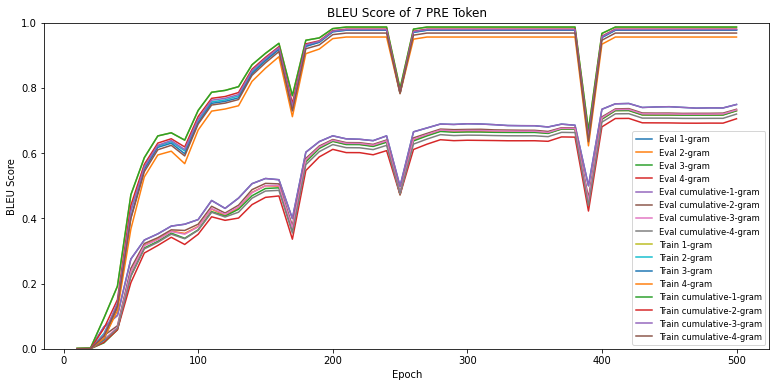

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 6))
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['1-gram'], label='Eval 1-gram')
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['2-gram'], label='Eval 2-gram')
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['3-gram'], label='Eval 3-gram')
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['4-gram'], label='Eval 4-gram')
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['cumulative-1-gram'], label='Eval cumulative-1-gram')
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['cumulative-2-gram'], label='Eval cumulative-2-gram')
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['cumulative-3-gram'], label='Eval cumulative-3-gram')
plt.plot(bleu_score_eval['Epoch'], bleu_score_eval['cumulative-4-gram'], label='Eval cumulative-4-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['1-gram'], label='Train 1-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['2-gram'], label='Train 2-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['3-gram'], label='Train 3-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['4-gram'], label='Train 4-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['cumulative-1-gram'], label='Train cumulative-1-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['cumulative-2-gram'], label='Train cumulative-2-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['cumulative-3-gram'], label='Train cumulative-3-gram')
plt.plot(bleu_score_train['Epoch'], bleu_score_train['cumulative-4-gram'], label='Train cumulative-4-gram')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.ylim(0, 1)
plt.title('BLEU Score of 7 PRE Token')
# make legend smaller
plt.legend(fontsize='small')
# add number for each 100 epoch

In [19]:
# get best 4-cumulative-gram row, outuput eppoch and other score
best_row = bleu_score_eval.loc[bleu_score_eval['cumulative-4-gram'].idxmax()]
best_epoch = best_row['Epoch']
best_score = best_row['cumulative-4-gram']
print(f'Best BLEU Score on Eval: {best_score:.4f} at Epoch {best_epoch}')
train_score = bleu_score_train.loc[bleu_score_train['Epoch'] == best_epoch]
print(f'Train Score: {train_score["cumulative-4-gram"].values[0]:.4f}')

Best BLEU Score on Eval: 0.7208 at Epoch 420
Train Score: 0.9680


In [23]:
test_question = "pak fitra penelitian apa "
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> pak fitra penelitian apa 
A <<< affective computing, affective engineering, intelligent system, data mining, educational data mining


In [20]:
test_question = "ketua bpj teh saha ieu"
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> ketua bpj teh saha ieu
A <<< agus wahyu widodo, muhammaddibajari pendidikan tinggi te


In [21]:
test_question = "kepala program studi sarjana sistem informasi teh saha"
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> kepala program studi sarjana sistem informasi teh saha
A <<< yusi tyroni mursityo, s.kom., m.s.


In [22]:
for i in range(len(qa_paired_eval)):
    test_question = qa_paired_eval['Pertanyaan'].iloc[i]
    outputs = model.generate(test_question)
    decoded_output = model.dec_tokenizer.decode(outputs[0])
    qa_paired_eval.loc[i, 'Predicted Answer'] = decoded_output

In [24]:
qa_paired_eval.to_excel('qa_paired_eval_091024_7pre.xlsx', index=False)

: 

In [15]:
torch.save(model.state_dict(), 'FLUENTSOTA_091024_7PRE.pth')